### Imports

In [1]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.60.jpg  
  inflating: cats_and_dogs/train/dogs/dog.858.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.858.jpg  
  inflating: cats_and_dogs/train/dogs/dog.680.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.680.jpg  
  inflating: cats_and_dogs/train/dogs/dog.694.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.694.jpg  
  inflating: cats_and_dogs/train/dogs/dog.864.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.864.jpg  
  inflating: cats_and_dogs/train/dogs/dog.870.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.870.jpg  
  inflating: cats_and_dogs/train/dogs/dog.871.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.871.jpg  
  inflating: cats_and_dogs/train/dogs/dog.865.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.865.jpg  
  inflating: cats_and_dogs/train/dogs/dog.695.jpg  
  inflating: __MACOSX/cats_and

### Definition of paths and specifications

Here, let's define the paths to the downloaded data and the training specifications of our model. We will also use a batch size of 128 and train the model for 15 epochs, which are the same specs used in the main course notebook.

In [3]:
PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
img_height = 150
img_width = 150

First, let's apply rescaling to normalize pixel values to the range [0, 1].

In [4]:
datagen = ImageDataGenerator(
    rescale=1./255
)
train_data_gen = datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)
val_data_gen = datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)
test_data_gen = datagen.flow_from_directory(
    PATH,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False,
    classes=['test']
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


Let's check some images to test our plot function:

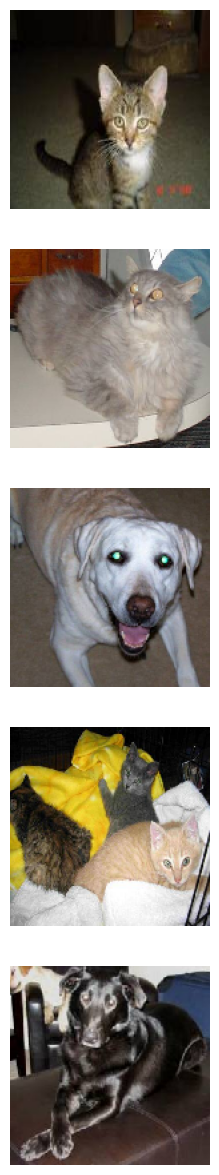

In [5]:
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5, len(images_arr) * 3))

    if probabilities is False:
        for img, ax in zip(images_arr, axes):
            ax.imshow(img)
            ax.axis('off')
    else:
        for img, probability, ax in zip(images_arr, probabilities, axes):
            ax.imshow(img)
            ax.axis('off')
            if probability > 0.5:
                ax.set_title("dog")
            else:
                ax.set_title("cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])

As the dataset isn't large enough, we will augment the data by flipping the images horizontally and vertically, and by aplying random transformations with a built-in layer inside the model.

In [6]:
train_image_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(img_height, img_width),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

Found 2000 images belonging to 2 classes.


Below are some examples of augmented images:

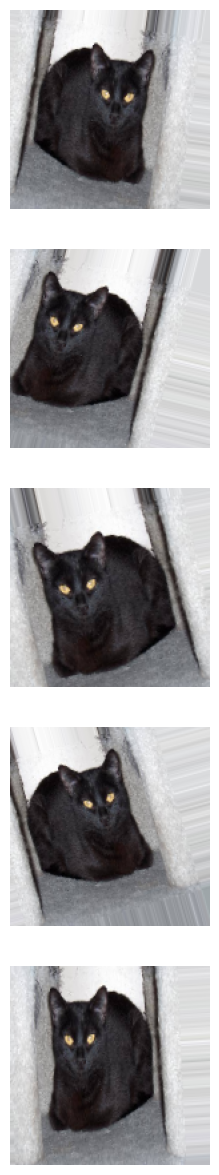

In [7]:
plotImages(augmented_images)

## Building the model

For this notebook, we will work with a simple CNN model with the following architecture:

In [8]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Also saving weights of the model to use in the future.

In [9]:
checkpoint_path = './checkpoints_2/training'

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

history = model.fit(
    train_data_gen,
    steps_per_epoch=train_data_gen.samples // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=val_data_gen.samples // batch_size,
    callbacks=[cp_callback]
)

Epoch 1/15
15/15 [==============================] - ETA: 0s - loss: 0.8824 - accuracy: 0.5027
Epoch 1: saving model to ./checkpoints_2/training
15/15 [==============================] - 24s 1s/step - loss: 0.8824 - accuracy: 0.5027 - val_loss: 0.6916 - val_accuracy: 0.5022
Epoch 2/15
15/15 [==============================] - ETA: 0s - loss: 0.6895 - accuracy: 0.5198
Epoch 2: saving model to ./checkpoints_2/training
15/15 [==============================] - 18s 1s/step - loss: 0.6895 - accuracy: 0.5198 - val_loss: 0.6946 - val_accuracy: 0.4989
Epoch 3/15
15/15 [==============================] - ETA: 0s - loss: 0.6778 - accuracy: 0.5620
Epoch 3: saving model to ./checkpoints_2/training
15/15 [==============================] - 15s 1s/step - loss: 0.6778 - accuracy: 0.5620 - val_loss: 0.7438 - val_accuracy: 0.5179
Epoch 4/15
15/15 [==============================] - ETA: 0s - loss: 0.6689 - accuracy: 0.5896
Epoch 4: saving model to ./checkpoints_2/training
15/15 [==============================

## Validation and metrics

Let's evaluate the model on its own calculated metrics based on validation during training and plot the loss and accuracy graphs.

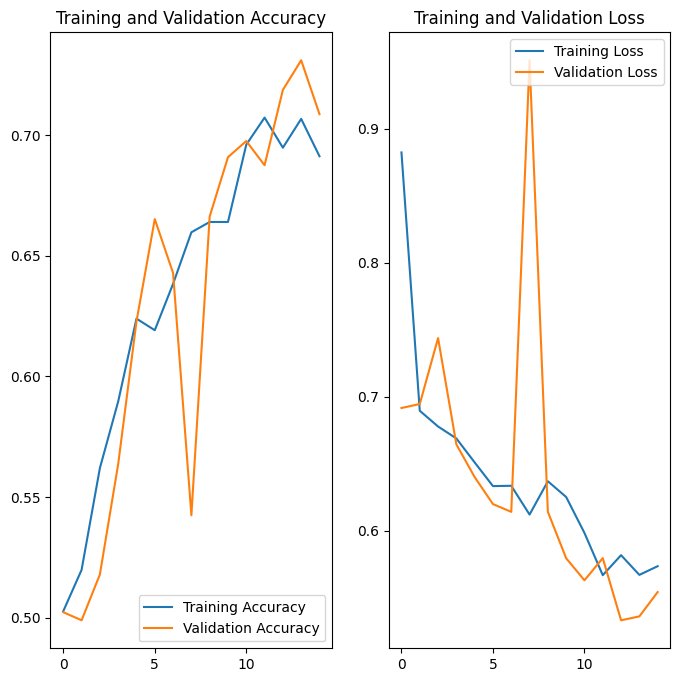

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

We can see that the model isn't overfitting, as the validation loss and accuracy are very close to the training loss and accuracy. Below we check how our model performs on the test set:

In [11]:
predictions = model.predict(test_data_gen, steps=len(test_data_gen))

threshold = 0.5
predicted_labels = (predictions > threshold).astype(int)

probabilities = []  # List to store integer labels

for i in range(len(test_data_gen)):
    batch_images, batch_labels = test_data_gen[i]

    # Predicted labels for the current batch
    batch_predicted_labels = predicted_labels[i * batch_size: (i + 1) * batch_size]

    # Iterate over images in the batch
    for j in range(len(batch_images)):
        image = batch_images[j]
        true_label = int(batch_labels[j])  # True label from the generator
        predicted_label = batch_predicted_labels[j].tolist()[0]  # Predicted label from the model

        probabilities.append(predicted_label)

1/1 [==============================] - 1s 677ms/step


<ipython-input-11-51a87a201d54>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  true_label = int(batch_labels[j])  # True label from the generator


The plotted images show the predicted labels. We can see that the model is doing a good job in classifying the images.

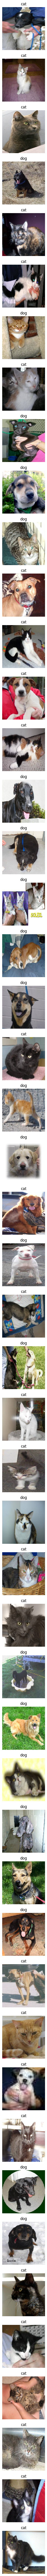

In [12]:
sample_test_images, _ = next(test_data_gen)
plotImages(sample_test_images, probabilities=probabilities)

## Challenge submission

Finally, we'll run the model and submit it to the challenge.

In [13]:
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 74.0% of the images of cats and dogs.
You passed the challenge!
